In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn
import pickle as pkl 

from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
%matplotlib inline

# Data Exploration

In this notebook, we want to first explore our heartbeat data, then train, validate, and test a number of machine learning techniques in order to identify outliers in the data. This problem is effectively the same as binary classification. Our input is a hearbeat pattern and the output is either a 0 for `not an outlier` or 1 for `outlier`. 

In [17]:
with open('data/train_data.pkl', "rb") as input_file:
    train_data = pkl.load(input_file)

In [18]:
len(train_data['train_x'])

349

In [19]:
type(train_data['train_y'][0])

bool

In [20]:
type(train_data['train_x'])

list

It looks like our data is a dictionary with keys `train_x` and `train_y`. `train_x` contains a list of 349 heartbeat traces and `train_y` are the labels for each heartbeat, so either true for good heartbeats and false for bad heartbeats. Each of the elements of the list contain a 1000 element 1d numpy array. 

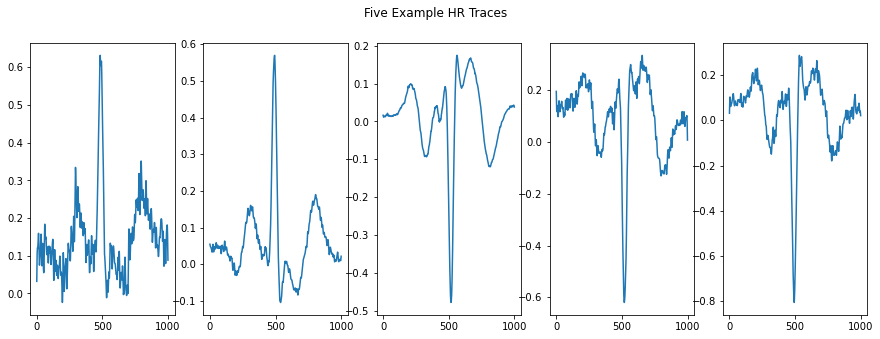

In [21]:
plotting_x = np.arange(1000)
num_plots = 5
fig, axs = plt.subplots(1, num_plots, figsize = (15,5))
fig.suptitle('Five Example HR Traces')
for plot in range(num_plots):
    axs[plot].plot(plotting_x, train_data['train_x'][plot])

Interesting, we can visually see some differences already. Let's take a look at the labels for these first five traces. 

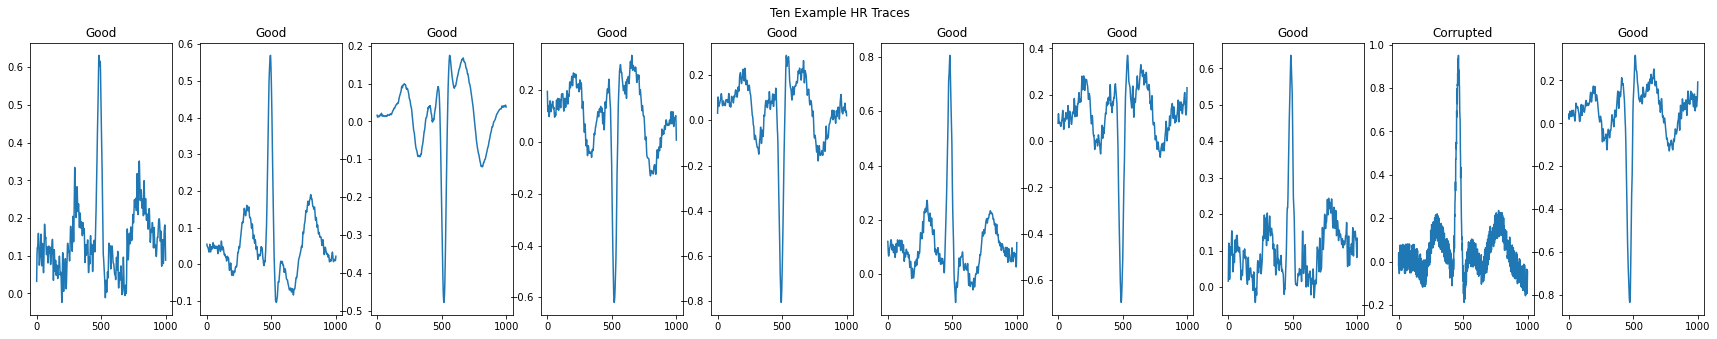

In [22]:
plotting_x = np.arange(1000)
num_plots = 10
fig, axs = plt.subplots(1, num_plots, figsize = (30,5))
fig.suptitle('Ten Example HR Traces')
for plot in range(num_plots):
    axs[plot].plot(plotting_x, train_data['train_x'][plot])
    title = 'Good' if train_data['train_y'][plot] else 'Corrupted'
    axs[plot].title.set_text(title)
    


Interesting, it looks like the differences we were seeing before were normal differences. The 9th item here is the only corrupted heart rate trace that we see. Visually, it looks more noisy, but we'll need more than just that to try and predict this. 

## Classes

Let's try and figure out how much data in each class we have. It could be a problem if our corrupted data is far too small. 

In [23]:
train_data['train_y'] = np.array(train_data['train_y'])

In [24]:
noncorrupted_count = np.count_nonzero(train_data['train_y']) # Number of noncorrupted items
noncorrupted_count

295

In [25]:
corrupted_count = train_data['train_y'].size - noncorrupted_count

Text(0.5, 1.0, 'Class Data Imbalance')

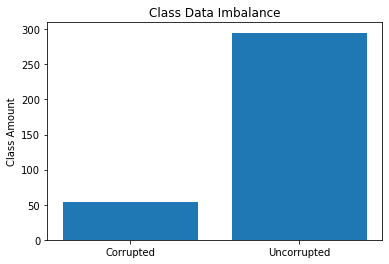

In [26]:
plt.bar(['Corrupted', 'Uncorrupted'],[corrupted_count, noncorrupted_count])
plt.ylabel('Class Amount')
plt.title('Class Data Imbalance')

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(np.array(train_data['train_x']))
train_data['pca-one'] = pca_result[:,0]
train_data['pca-two'] = pca_result[:,1]
train_data['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.27011316 0.20521693 0.13920123]


In [30]:
df = pd.DataFrame.from_dict(train_data)

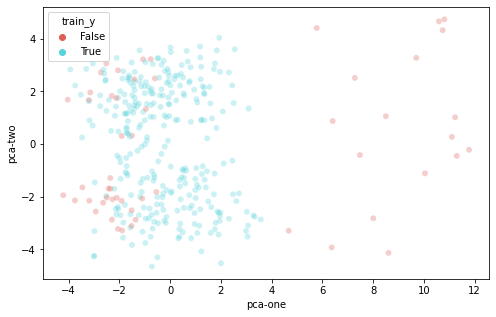

In [48]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="train_y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)


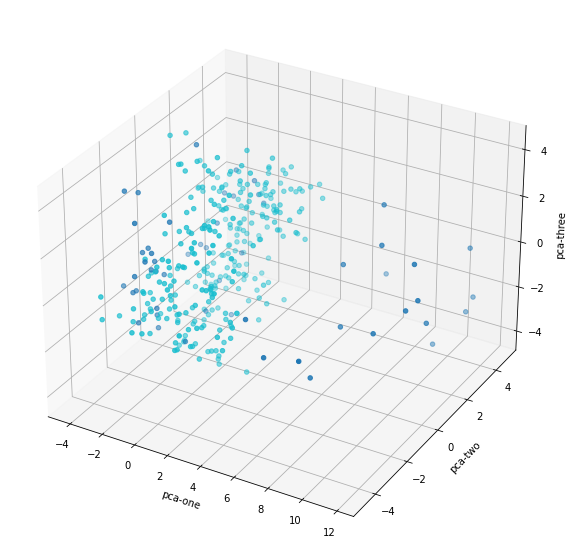

In [35]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["train_y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [41]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.array(train_data['train_x']))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 349 samples in 0.000s...
[t-SNE] Computed neighbors for 349 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 349 / 349
[t-SNE] Mean sigma: 2.245066
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.290897
[t-SNE] KL divergence after 300 iterations: 0.344325


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

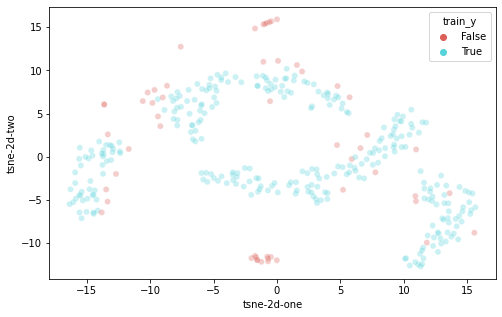

In [42]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="train_y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)

In [44]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(train_data['train_x'])
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))


Cumulative explained variation for 50 principal components: 0.9903574810438077


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 349 samples in 0.000s...
[t-SNE] Computed neighbors for 349 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 349 / 349
[t-SNE] Mean sigma: 2.244612
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.859074
[t-SNE] KL divergence after 300 iterations: 0.317180


<AxesSubplot:xlabel='pca+tsne-2d-one', ylabel='pca+tsne-2d-two'>

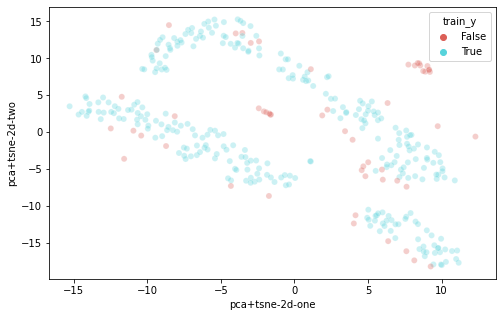

In [47]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_50)
df['pca+tsne-2d-one'] = tsne_results[:,0]
df['pca+tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="pca+tsne-2d-one", y="pca+tsne-2d-two",
    hue="train_y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3
)

Yikes, it looks like we have nearly 6 times as much noncorrupted data as corrupted data. This was mildly expected, but it's a problem we'll have to deal with later on. For now, let's start simple and see how we do. 

# Analysis

Since our dataset is quite limited we'll be using `k-fold cross-validation` in lieu of a standard train test split. Let's start with `k=10`. 

In [47]:
kfold = KFold(10, shuffle = True,random_state =  1)
indices = np.arange(len(train_data['train_x']))

In [48]:
for train, test in kfold.split(indices): 
    print('train: %s, test: %s' % (len(train), len(test)))

train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 315, test: 34


## Linear Classifier

Let's start with a linear classifier. This is equivalent to a perceptron, so let's just implement a perceptron in pytorch. 

### Let's start with our hyperparameters. 

This will be the number of epochs - number of times we iterate over our dataset, batch size, and learning rate. 

In [91]:
epochs = 150
batch_size = 315 
learning_rate = .001

In [92]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [93]:
class Perceptron(nn.Module):
    def __init__(self, input_size = 1000):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    def forward(self, inputs):
        return self.linear(inputs)
    

In [113]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


def perf_measure(y_hat, y_actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    y_pred_tag = torch.round(torch.sigmoid(y_hat))
    y_actual = torch.FloatTensor(y_actual)
    
    for i in range(len(y_pred_tag)): 
        y_pred_tag[i] = int(y_pred_tag[i])
        y_actual[i] = int(y_actual[i])
        if y_actual[i]==y_pred_tag[i]==1:
            TP += 1
        if y_pred_tag[i]==1 and y_actual[i].item()!=y_pred_tag[i]:
            FP += 1
        if y_actual[i]==y_pred_tag[i]==0:
            TN += 1
        if y_pred_tag[i]==0 and y_actual[i]!=y_pred_tag[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [111]:
def train(network):
    for train, test in kfold.split(indices): 
        print()
        X_train = np.copy(np.array(train_data['train_x'])[train])
        y_train = np.copy(np.array(train_data['train_y'])[train])
        X_test = np.copy(np.array(train_data['train_x'])[test])
        y_test = np.copy(np.array(train_data['train_y'])[test])
        traindata = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
        testdata = testData(torch.FloatTensor(X_test))
        train_loader = DataLoader(dataset=traindata, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=testdata, batch_size=1)
        model = network()
        device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        model.to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        model.train()
        for e in range(1, epochs+1):
            epoch_loss = 0
            epoch_acc = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                epoch_acc += acc.item()


            print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


        model.eval()
        y_hat = []
        for test in test_loader: 
            test = test.to(device)
            y_hat.append(model(test))
        test_accuracy = binary_acc(torch.FloatTensor(y_hat), torch.FloatTensor(y_test)).item()
        TP, FP, TN, FN = perf_measure(torch.FloatTensor(y_hat), y_test)

        print("This fold ended with a test accuracy of {}, TP: {}, FP: {}, TN: {}, FN: {}".format(test_accuracy, TP, FP, TN, FN))


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4320938/

https://arxiv.org/pdf/1901.09972.pdf

In [112]:
train(Perceptron)


Epoch 001: | Loss: 0.70443 | Acc: 29.000
Epoch 002: | Loss: 0.68775 | Acc: 60.000
Epoch 003: | Loss: 0.67383 | Acc: 74.000
Epoch 004: | Loss: 0.66259 | Acc: 75.000
Epoch 005: | Loss: 0.65381 | Acc: 78.000
Epoch 006: | Loss: 0.64711 | Acc: 79.000
Epoch 007: | Loss: 0.64208 | Acc: 79.000
Epoch 008: | Loss: 0.63832 | Acc: 80.000
Epoch 009: | Loss: 0.63545 | Acc: 80.000
Epoch 010: | Loss: 0.63319 | Acc: 80.000
Epoch 011: | Loss: 0.63132 | Acc: 81.000
Epoch 012: | Loss: 0.62968 | Acc: 82.000
Epoch 013: | Loss: 0.62816 | Acc: 82.000
Epoch 014: | Loss: 0.62666 | Acc: 82.000
Epoch 015: | Loss: 0.62515 | Acc: 82.000
Epoch 016: | Loss: 0.62357 | Acc: 82.000
Epoch 017: | Loss: 0.62191 | Acc: 82.000
Epoch 018: | Loss: 0.62018 | Acc: 82.000
Epoch 019: | Loss: 0.61836 | Acc: 82.000
Epoch 020: | Loss: 0.61647 | Acc: 81.000
Epoch 021: | Loss: 0.61453 | Acc: 81.000
Epoch 022: | Loss: 0.61255 | Acc: 81.000
Epoch 023: | Loss: 0.61054 | Acc: 82.000
Epoch 024: | Loss: 0.60852 | Acc: 82.000
Epoch 025: | Lo

Epoch 043: | Loss: 0.56143 | Acc: 82.000
Epoch 044: | Loss: 0.56000 | Acc: 82.000
Epoch 045: | Loss: 0.55860 | Acc: 82.000
Epoch 046: | Loss: 0.55722 | Acc: 82.000
Epoch 047: | Loss: 0.55588 | Acc: 82.000
Epoch 048: | Loss: 0.55457 | Acc: 82.000
Epoch 049: | Loss: 0.55327 | Acc: 82.000
Epoch 050: | Loss: 0.55199 | Acc: 83.000
Epoch 051: | Loss: 0.55072 | Acc: 83.000
Epoch 052: | Loss: 0.54947 | Acc: 83.000
Epoch 053: | Loss: 0.54822 | Acc: 83.000
Epoch 054: | Loss: 0.54697 | Acc: 83.000
Epoch 055: | Loss: 0.54573 | Acc: 82.000
Epoch 056: | Loss: 0.54449 | Acc: 82.000
Epoch 057: | Loss: 0.54327 | Acc: 82.000
Epoch 058: | Loss: 0.54205 | Acc: 82.000
Epoch 059: | Loss: 0.54084 | Acc: 82.000
Epoch 060: | Loss: 0.53964 | Acc: 82.000
Epoch 061: | Loss: 0.53845 | Acc: 82.000
Epoch 062: | Loss: 0.53728 | Acc: 82.000
Epoch 063: | Loss: 0.53612 | Acc: 82.000
Epoch 064: | Loss: 0.53496 | Acc: 82.000
Epoch 065: | Loss: 0.53382 | Acc: 83.000
Epoch 066: | Loss: 0.53269 | Acc: 83.000
Epoch 067: | Los

Epoch 087: | Loss: 0.51805 | Acc: 82.000
Epoch 088: | Loss: 0.51704 | Acc: 82.000
Epoch 089: | Loss: 0.51603 | Acc: 83.000
Epoch 090: | Loss: 0.51503 | Acc: 83.000
Epoch 091: | Loss: 0.51404 | Acc: 83.000
Epoch 092: | Loss: 0.51306 | Acc: 83.000
Epoch 093: | Loss: 0.51208 | Acc: 83.000
Epoch 094: | Loss: 0.51111 | Acc: 83.000
Epoch 095: | Loss: 0.51015 | Acc: 83.000
Epoch 096: | Loss: 0.50920 | Acc: 83.000
Epoch 097: | Loss: 0.50826 | Acc: 83.000
Epoch 098: | Loss: 0.50732 | Acc: 83.000
Epoch 099: | Loss: 0.50639 | Acc: 83.000
Epoch 100: | Loss: 0.50547 | Acc: 83.000
Epoch 101: | Loss: 0.50455 | Acc: 83.000
Epoch 102: | Loss: 0.50364 | Acc: 83.000
Epoch 103: | Loss: 0.50274 | Acc: 83.000
Epoch 104: | Loss: 0.50184 | Acc: 83.000
Epoch 105: | Loss: 0.50096 | Acc: 83.000
Epoch 106: | Loss: 0.50008 | Acc: 83.000
Epoch 107: | Loss: 0.49920 | Acc: 83.000
Epoch 108: | Loss: 0.49834 | Acc: 83.000
Epoch 109: | Loss: 0.49748 | Acc: 83.000
Epoch 110: | Loss: 0.49662 | Acc: 83.000
Epoch 111: | Los

Epoch 148: | Loss: 0.43249 | Acc: 87.000
Epoch 149: | Loss: 0.43181 | Acc: 87.000
Epoch 150: | Loss: 0.43113 | Acc: 87.000
tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.])
tensor([0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.])
This fold ended with a test accuracy of 80.0, TP: 25, FP: 3, TN: 3, FN: 4

Epoch 001: | Loss: 0.67941 | Acc: 68.000
Epoch 002: | Loss: 0.66457 | Acc: 77.000
Epoch 003: | Loss: 0.65252 | Acc: 79.000
Epoch 004: | Loss: 0.64305 | Acc: 80.000
Epoch 005: | Loss: 0.63583 | Acc: 82.000
Epoch 006: | Loss: 0.63038 | Acc: 82.000
Epoch 007: | Loss: 0.62626 | Acc: 83.000
Epoch 008: | Loss: 0.62308 | Acc: 83.000
Epoch 009: | Loss: 0.62053 | Acc: 83.000
Epoch 010: | Loss: 0.61838 | Acc: 83.000
Epoch 011: | Loss: 0.61645 | Acc: 83.000
Epoch 012: | Loss: 0.61462 | Acc: 82.

Epoch 032: | Loss: 0.57503 | Acc: 80.000
Epoch 033: | Loss: 0.57307 | Acc: 80.000
Epoch 034: | Loss: 0.57115 | Acc: 80.000
Epoch 035: | Loss: 0.56926 | Acc: 80.000
Epoch 036: | Loss: 0.56740 | Acc: 80.000
Epoch 037: | Loss: 0.56557 | Acc: 81.000
Epoch 038: | Loss: 0.56376 | Acc: 81.000
Epoch 039: | Loss: 0.56197 | Acc: 81.000
Epoch 040: | Loss: 0.56021 | Acc: 81.000
Epoch 041: | Loss: 0.55847 | Acc: 82.000
Epoch 042: | Loss: 0.55676 | Acc: 81.000
Epoch 043: | Loss: 0.55508 | Acc: 81.000
Epoch 044: | Loss: 0.55343 | Acc: 81.000
Epoch 045: | Loss: 0.55182 | Acc: 81.000
Epoch 046: | Loss: 0.55023 | Acc: 81.000
Epoch 047: | Loss: 0.54867 | Acc: 81.000
Epoch 048: | Loss: 0.54713 | Acc: 82.000
Epoch 049: | Loss: 0.54562 | Acc: 82.000
Epoch 050: | Loss: 0.54411 | Acc: 82.000
Epoch 051: | Loss: 0.54263 | Acc: 82.000
Epoch 052: | Loss: 0.54115 | Acc: 82.000
Epoch 053: | Loss: 0.53968 | Acc: 82.000
Epoch 054: | Loss: 0.53822 | Acc: 82.000
Epoch 055: | Loss: 0.53677 | Acc: 82.000
Epoch 056: | Los

Epoch 085: | Loss: 0.50271 | Acc: 84.000
Epoch 086: | Loss: 0.50164 | Acc: 84.000
Epoch 087: | Loss: 0.50058 | Acc: 84.000
Epoch 088: | Loss: 0.49952 | Acc: 84.000
Epoch 089: | Loss: 0.49848 | Acc: 84.000
Epoch 090: | Loss: 0.49745 | Acc: 84.000
Epoch 091: | Loss: 0.49644 | Acc: 84.000
Epoch 092: | Loss: 0.49543 | Acc: 84.000
Epoch 093: | Loss: 0.49443 | Acc: 84.000
Epoch 094: | Loss: 0.49344 | Acc: 84.000
Epoch 095: | Loss: 0.49247 | Acc: 84.000
Epoch 096: | Loss: 0.49150 | Acc: 84.000
Epoch 097: | Loss: 0.49054 | Acc: 84.000
Epoch 098: | Loss: 0.48959 | Acc: 84.000
Epoch 099: | Loss: 0.48866 | Acc: 84.000
Epoch 100: | Loss: 0.48773 | Acc: 84.000
Epoch 101: | Loss: 0.48681 | Acc: 84.000
Epoch 102: | Loss: 0.48589 | Acc: 84.000
Epoch 103: | Loss: 0.48499 | Acc: 84.000
Epoch 104: | Loss: 0.48410 | Acc: 84.000
Epoch 105: | Loss: 0.48321 | Acc: 84.000
Epoch 106: | Loss: 0.48234 | Acc: 84.000
Epoch 107: | Loss: 0.48147 | Acc: 84.000
Epoch 108: | Loss: 0.48061 | Acc: 84.000
Epoch 109: | Los

Epoch 138: | Loss: 0.45585 | Acc: 86.000
Epoch 139: | Loss: 0.45516 | Acc: 86.000
Epoch 140: | Loss: 0.45448 | Acc: 86.000
Epoch 141: | Loss: 0.45379 | Acc: 87.000
Epoch 142: | Loss: 0.45312 | Acc: 87.000
Epoch 143: | Loss: 0.45245 | Acc: 87.000
Epoch 144: | Loss: 0.45178 | Acc: 87.000
Epoch 145: | Loss: 0.45112 | Acc: 87.000
Epoch 146: | Loss: 0.45046 | Acc: 87.000
Epoch 147: | Loss: 0.44980 | Acc: 87.000
Epoch 148: | Loss: 0.44915 | Acc: 87.000
Epoch 149: | Loss: 0.44850 | Acc: 87.000
Epoch 150: | Loss: 0.44786 | Acc: 87.000
tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])
This fold ended with a test accuracy of 89.0, TP: 31, FP: 1, TN: 0, FN: 3

Epoch 001: | Loss: 0.68309 | Acc: 61.000
Epoch 002: | Loss: 0.66883 | Acc: 69.

Epoch 022: | Loss: 0.61229 | Acc: 81.000
Epoch 023: | Loss: 0.61028 | Acc: 81.000
Epoch 024: | Loss: 0.60826 | Acc: 81.000
Epoch 025: | Loss: 0.60623 | Acc: 81.000
Epoch 026: | Loss: 0.60422 | Acc: 81.000
Epoch 027: | Loss: 0.60225 | Acc: 81.000
Epoch 028: | Loss: 0.60032 | Acc: 81.000
Epoch 029: | Loss: 0.59845 | Acc: 80.000
Epoch 030: | Loss: 0.59664 | Acc: 81.000
Epoch 031: | Loss: 0.59489 | Acc: 80.000
Epoch 032: | Loss: 0.59319 | Acc: 81.000
Epoch 033: | Loss: 0.59155 | Acc: 81.000
Epoch 034: | Loss: 0.58994 | Acc: 81.000
Epoch 035: | Loss: 0.58836 | Acc: 82.000
Epoch 036: | Loss: 0.58679 | Acc: 82.000
Epoch 037: | Loss: 0.58523 | Acc: 82.000
Epoch 038: | Loss: 0.58366 | Acc: 82.000
Epoch 039: | Loss: 0.58208 | Acc: 82.000
Epoch 040: | Loss: 0.58049 | Acc: 82.000
Epoch 041: | Loss: 0.57888 | Acc: 82.000
Epoch 042: | Loss: 0.57727 | Acc: 82.000
Epoch 043: | Loss: 0.57565 | Acc: 82.000
Epoch 044: | Loss: 0.57403 | Acc: 82.000
Epoch 045: | Loss: 0.57242 | Acc: 82.000
Epoch 046: | Los

In [104]:
class MLP(nn.Module):
    def __init__(self, input_size = 1000):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, input_size//2)
        self.l2 = nn.Linear(input_size//2, input_size//4)
        self.l3 = nn.Linear(input_size//4, 1)
    def forward(self, inputs):
        relu = torch.nn.ReLU()
        inputs = relu(self.l1(inputs))
        inputs = relu(self.l2(inputs))
        inputs = relu(self.l3(inputs))
        return inputs

In [118]:
epochs = 100
batch_size = 64 
learning_rate = .001
train(MLP)


Epoch 001: | Loss: 0.69315 | Acc: 16.000
Epoch 002: | Loss: 0.69315 | Acc: 15.800
Epoch 003: | Loss: 0.69315 | Acc: 16.000
Epoch 004: | Loss: 0.69315 | Acc: 16.000
Epoch 005: | Loss: 0.69315 | Acc: 16.000
Epoch 006: | Loss: 0.69315 | Acc: 16.000
Epoch 007: | Loss: 0.69315 | Acc: 16.000
Epoch 008: | Loss: 0.69315 | Acc: 16.000
Epoch 009: | Loss: 0.69315 | Acc: 16.000
Epoch 010: | Loss: 0.69315 | Acc: 16.000
Epoch 011: | Loss: 0.69315 | Acc: 16.000
Epoch 012: | Loss: 0.69315 | Acc: 15.800
Epoch 013: | Loss: 0.69315 | Acc: 16.000
Epoch 014: | Loss: 0.69315 | Acc: 15.800
Epoch 015: | Loss: 0.69315 | Acc: 15.800
Epoch 016: | Loss: 0.69315 | Acc: 16.000
Epoch 017: | Loss: 0.69315 | Acc: 15.800
Epoch 018: | Loss: 0.69315 | Acc: 16.000
Epoch 019: | Loss: 0.69315 | Acc: 16.000
Epoch 020: | Loss: 0.69315 | Acc: 15.800
Epoch 021: | Loss: 0.69315 | Acc: 15.800
Epoch 022: | Loss: 0.69315 | Acc: 16.000
Epoch 023: | Loss: 0.69315 | Acc: 16.000
Epoch 024: | Loss: 0.69315 | Acc: 16.000
Epoch 025: | Lo

This fold ended with a test accuracy of 94.0, TP: 27, FP: 2, TN: 6, FN: 0

Epoch 001: | Loss: 0.59946 | Acc: 84.400
Epoch 002: | Loss: 0.50671 | Acc: 84.200
Epoch 003: | Loss: 0.38136 | Acc: 85.800
Epoch 004: | Loss: 0.32042 | Acc: 89.600
Epoch 005: | Loss: 0.25766 | Acc: 92.800
Epoch 006: | Loss: 0.20973 | Acc: 94.600
Epoch 007: | Loss: 0.18639 | Acc: 94.200
Epoch 008: | Loss: 0.16002 | Acc: 97.400
Epoch 009: | Loss: 0.14211 | Acc: 98.000
Epoch 010: | Loss: 0.12910 | Acc: 98.600
Epoch 011: | Loss: 0.12383 | Acc: 98.600
Epoch 012: | Loss: 0.11665 | Acc: 99.000
Epoch 013: | Loss: 0.11293 | Acc: 99.200
Epoch 014: | Loss: 0.11166 | Acc: 99.600
Epoch 015: | Loss: 0.11171 | Acc: 99.200
Epoch 016: | Loss: 0.11354 | Acc: 100.000
Epoch 017: | Loss: 0.11377 | Acc: 99.600
Epoch 018: | Loss: 0.10976 | Acc: 100.000
Epoch 019: | Loss: 0.11066 | Acc: 99.200
Epoch 020: | Loss: 0.10858 | Acc: 99.600
Epoch 021: | Loss: 0.10913 | Acc: 99.600
Epoch 022: | Loss: 0.10937 | Acc: 100.000
Epoch 023: | Loss: 0

Epoch 096: | Loss: 0.10646 | Acc: 100.000
Epoch 097: | Loss: 0.10556 | Acc: 100.000
Epoch 098: | Loss: 0.10489 | Acc: 100.000
Epoch 099: | Loss: 0.10578 | Acc: 100.000
Epoch 100: | Loss: 0.10690 | Acc: 100.000
This fold ended with a test accuracy of 91.0, TP: 29, FP: 3, TN: 3, FN: 0

Epoch 001: | Loss: 0.63890 | Acc: 73.800
Epoch 002: | Loss: 0.50673 | Acc: 84.600
Epoch 003: | Loss: 0.39562 | Acc: 86.000
Epoch 004: | Loss: 0.31798 | Acc: 87.400
Epoch 005: | Loss: 0.25803 | Acc: 91.800
Epoch 006: | Loss: 0.21762 | Acc: 93.600
Epoch 007: | Loss: 0.18484 | Acc: 96.200
Epoch 008: | Loss: 0.16046 | Acc: 96.400
Epoch 009: | Loss: 0.14398 | Acc: 97.400
Epoch 010: | Loss: 0.12706 | Acc: 98.600
Epoch 011: | Loss: 0.12229 | Acc: 98.600
Epoch 012: | Loss: 0.11845 | Acc: 98.400
Epoch 013: | Loss: 0.11545 | Acc: 99.000
Epoch 014: | Loss: 0.11375 | Acc: 99.000
Epoch 015: | Loss: 0.11578 | Acc: 98.200
Epoch 016: | Loss: 0.12920 | Acc: 99.200
Epoch 017: | Loss: 0.11612 | Acc: 99.600
Epoch 018: | Loss:

Epoch 094: | Loss: 0.69315 | Acc: 14.200
Epoch 095: | Loss: 0.69315 | Acc: 14.400
Epoch 096: | Loss: 0.69315 | Acc: 14.400
Epoch 097: | Loss: 0.69315 | Acc: 14.200
Epoch 098: | Loss: 0.69315 | Acc: 14.200
Epoch 099: | Loss: 0.69315 | Acc: 14.400
Epoch 100: | Loss: 0.69315 | Acc: 14.200
This fold ended with a test accuracy of 26.0, TP: 0, FP: 0, TN: 9, FN: 26

Epoch 001: | Loss: 0.69315 | Acc: 16.200
Epoch 002: | Loss: 0.69315 | Acc: 16.400
Epoch 003: | Loss: 0.69315 | Acc: 16.800
Epoch 004: | Loss: 0.69315 | Acc: 16.600
Epoch 005: | Loss: 0.69315 | Acc: 16.600
Epoch 006: | Loss: 0.69315 | Acc: 16.600
Epoch 007: | Loss: 0.69315 | Acc: 16.200
Epoch 008: | Loss: 0.69315 | Acc: 16.600
Epoch 009: | Loss: 0.69315 | Acc: 16.400
Epoch 010: | Loss: 0.69315 | Acc: 16.400
Epoch 011: | Loss: 0.69315 | Acc: 16.600
Epoch 012: | Loss: 0.69315 | Acc: 16.400
Epoch 013: | Loss: 0.69315 | Acc: 16.800
Epoch 014: | Loss: 0.69315 | Acc: 16.400
Epoch 015: | Loss: 0.69315 | Acc: 16.600
Epoch 016: | Loss: 0.69

Epoch 096: | Loss: 0.69315 | Acc: 17.000
Epoch 097: | Loss: 0.69315 | Acc: 17.000
Epoch 098: | Loss: 0.69315 | Acc: 16.800
Epoch 099: | Loss: 0.69315 | Acc: 16.800
Epoch 100: | Loss: 0.69315 | Acc: 16.800
This fold ended with a test accuracy of 3.0, TP: 0, FP: 0, TN: 1, FN: 34

Epoch 001: | Loss: 0.69316 | Acc: 14.800
Epoch 002: | Loss: 0.69315 | Acc: 14.800
Epoch 003: | Loss: 0.69315 | Acc: 14.800
Epoch 004: | Loss: 0.69315 | Acc: 14.600
Epoch 005: | Loss: 0.69315 | Acc: 14.800
Epoch 006: | Loss: 0.69315 | Acc: 14.800
Epoch 007: | Loss: 0.69315 | Acc: 15.000
Epoch 008: | Loss: 0.69315 | Acc: 15.200
Epoch 009: | Loss: 0.69315 | Acc: 15.000
Epoch 010: | Loss: 0.69315 | Acc: 15.000
Epoch 011: | Loss: 0.69315 | Acc: 14.800
Epoch 012: | Loss: 0.69315 | Acc: 15.000
Epoch 013: | Loss: 0.69315 | Acc: 14.800
Epoch 014: | Loss: 0.69315 | Acc: 14.800
Epoch 015: | Loss: 0.69315 | Acc: 15.000
Epoch 016: | Loss: 0.69315 | Acc: 15.000
Epoch 017: | Loss: 0.69315 | Acc: 14.800
Epoch 018: | Loss: 0.693

Epoch 100: | Loss: 0.69315 | Acc: 15.200
This fold ended with a test accuracy of 18.0, TP: 0, FP: 0, TN: 6, FN: 28


In [130]:
class largerFNN(nn.Module):
    def __init__(self, input_size = 1000):
        super(largerFNN, self).__init__()
        self.l1 = nn.Linear(input_size, input_size//2)
        self.l2 = nn.Linear(input_size//2, input_size//4)
        self.l3 = nn.Linear(input_size//4, input_size//8)
        self.l4 = nn.Linear(input_size//8, 1)
    def forward(self, inputs):
        relu = torch.nn.ReLU()
        inputs = relu(self.l1(inputs))
        inputs = relu(self.l2(inputs))
        inputs = relu(self.l3(inputs))
        inputs = relu(self.l4(inputs))
        return inputs

In [132]:
epochs = 100
batch_size = 64 
learning_rate = .001
train(largerFNN)


Epoch 001: | Loss: 0.69315 | Acc: 16.000
Epoch 002: | Loss: 0.69315 | Acc: 16.200
Epoch 003: | Loss: 0.69315 | Acc: 15.800
Epoch 004: | Loss: 0.69315 | Acc: 16.000
Epoch 005: | Loss: 0.69315 | Acc: 15.800
Epoch 006: | Loss: 0.69315 | Acc: 16.200
Epoch 007: | Loss: 0.69315 | Acc: 16.000
Epoch 008: | Loss: 0.69315 | Acc: 15.600
Epoch 009: | Loss: 0.69315 | Acc: 16.000
Epoch 010: | Loss: 0.69315 | Acc: 15.800
Epoch 011: | Loss: 0.69315 | Acc: 15.800
Epoch 012: | Loss: 0.69315 | Acc: 15.800
Epoch 013: | Loss: 0.69315 | Acc: 16.000
Epoch 014: | Loss: 0.69315 | Acc: 16.000
Epoch 015: | Loss: 0.69315 | Acc: 15.800
Epoch 016: | Loss: 0.69315 | Acc: 15.800
Epoch 017: | Loss: 0.69315 | Acc: 16.000
Epoch 018: | Loss: 0.69315 | Acc: 15.800
Epoch 019: | Loss: 0.69315 | Acc: 16.000
Epoch 020: | Loss: 0.69315 | Acc: 16.000
Epoch 021: | Loss: 0.69315 | Acc: 16.200
Epoch 022: | Loss: 0.69315 | Acc: 15.800
Epoch 023: | Loss: 0.69315 | Acc: 16.000
Epoch 024: | Loss: 0.69315 | Acc: 16.000
Epoch 025: | Lo

Epoch 004: | Loss: 0.33954 | Acc: 88.400
Epoch 005: | Loss: 0.28280 | Acc: 91.200
Epoch 006: | Loss: 0.23178 | Acc: 93.600
Epoch 007: | Loss: 0.18895 | Acc: 95.400
Epoch 008: | Loss: 0.16999 | Acc: 97.000
Epoch 009: | Loss: 0.14052 | Acc: 97.600
Epoch 010: | Loss: 0.13415 | Acc: 98.400
Epoch 011: | Loss: 0.12611 | Acc: 98.600
Epoch 012: | Loss: 0.11669 | Acc: 99.200
Epoch 013: | Loss: 0.11680 | Acc: 99.000
Epoch 014: | Loss: 0.10994 | Acc: 100.000
Epoch 015: | Loss: 0.11204 | Acc: 99.600
Epoch 016: | Loss: 0.10995 | Acc: 99.600
Epoch 017: | Loss: 0.11063 | Acc: 100.000
Epoch 018: | Loss: 0.10947 | Acc: 99.600
Epoch 019: | Loss: 0.11042 | Acc: 99.600
Epoch 020: | Loss: 0.11048 | Acc: 100.000
Epoch 021: | Loss: 0.11070 | Acc: 100.000
Epoch 022: | Loss: 0.11061 | Acc: 99.600
Epoch 023: | Loss: 0.12092 | Acc: 99.000
Epoch 024: | Loss: 0.11286 | Acc: 99.600
Epoch 025: | Loss: 0.11522 | Acc: 99.400
Epoch 026: | Loss: 0.11451 | Acc: 99.600
Epoch 027: | Loss: 0.12490 | Acc: 98.600
Epoch 028: |

Epoch 006: | Loss: 0.69315 | Acc: 15.000
Epoch 007: | Loss: 0.69315 | Acc: 15.000
Epoch 008: | Loss: 0.69315 | Acc: 15.200
Epoch 009: | Loss: 0.69315 | Acc: 15.400
Epoch 010: | Loss: 0.69315 | Acc: 15.400
Epoch 011: | Loss: 0.69315 | Acc: 15.400
Epoch 012: | Loss: 0.69315 | Acc: 15.000
Epoch 013: | Loss: 0.69315 | Acc: 15.200
Epoch 014: | Loss: 0.69315 | Acc: 15.200
Epoch 015: | Loss: 0.69315 | Acc: 15.400
Epoch 016: | Loss: 0.69315 | Acc: 15.600
Epoch 017: | Loss: 0.69315 | Acc: 15.400
Epoch 018: | Loss: 0.69315 | Acc: 15.200
Epoch 019: | Loss: 0.69315 | Acc: 15.600
Epoch 020: | Loss: 0.69315 | Acc: 15.400
Epoch 021: | Loss: 0.69315 | Acc: 15.400
Epoch 022: | Loss: 0.69315 | Acc: 15.400
Epoch 023: | Loss: 0.69315 | Acc: 15.200
Epoch 024: | Loss: 0.69315 | Acc: 15.200
Epoch 025: | Loss: 0.69315 | Acc: 15.400
Epoch 026: | Loss: 0.69315 | Acc: 15.400
Epoch 027: | Loss: 0.69315 | Acc: 15.600
Epoch 028: | Loss: 0.69315 | Acc: 15.200
Epoch 029: | Loss: 0.69315 | Acc: 15.200
Epoch 030: | Los

Epoch 006: | Loss: 0.69315 | Acc: 16.400
Epoch 007: | Loss: 0.69315 | Acc: 16.400
Epoch 008: | Loss: 0.69315 | Acc: 16.800
Epoch 009: | Loss: 0.69315 | Acc: 16.800
Epoch 010: | Loss: 0.69315 | Acc: 16.800
Epoch 011: | Loss: 0.69315 | Acc: 16.600
Epoch 012: | Loss: 0.69315 | Acc: 16.600
Epoch 013: | Loss: 0.69315 | Acc: 16.600
Epoch 014: | Loss: 0.69315 | Acc: 16.400
Epoch 015: | Loss: 0.69315 | Acc: 16.600
Epoch 016: | Loss: 0.69315 | Acc: 16.600
Epoch 017: | Loss: 0.69315 | Acc: 16.400
Epoch 018: | Loss: 0.69315 | Acc: 16.400
Epoch 019: | Loss: 0.69315 | Acc: 16.600
Epoch 020: | Loss: 0.69315 | Acc: 16.600
Epoch 021: | Loss: 0.69315 | Acc: 16.800
Epoch 022: | Loss: 0.69315 | Acc: 16.400
Epoch 023: | Loss: 0.69315 | Acc: 16.600
Epoch 024: | Loss: 0.69315 | Acc: 16.600
Epoch 025: | Loss: 0.69315 | Acc: 16.200
Epoch 026: | Loss: 0.69315 | Acc: 16.600
Epoch 027: | Loss: 0.69315 | Acc: 16.800
Epoch 028: | Loss: 0.69315 | Acc: 16.800
Epoch 029: | Loss: 0.69315 | Acc: 16.400
Epoch 030: | Los

Epoch 006: | Loss: 0.21336 | Acc: 93.600
Epoch 007: | Loss: 0.18366 | Acc: 95.800
Epoch 008: | Loss: 0.16406 | Acc: 96.200
Epoch 009: | Loss: 0.13273 | Acc: 98.000
Epoch 010: | Loss: 0.12780 | Acc: 97.600
Epoch 011: | Loss: 0.11963 | Acc: 99.000
Epoch 012: | Loss: 0.11194 | Acc: 99.200
Epoch 013: | Loss: 0.11172 | Acc: 99.200
Epoch 014: | Loss: 0.11542 | Acc: 98.400
Epoch 015: | Loss: 0.11269 | Acc: 99.400
Epoch 016: | Loss: 0.10921 | Acc: 99.400
Epoch 017: | Loss: 0.10856 | Acc: 98.800
Epoch 018: | Loss: 0.10934 | Acc: 99.400
Epoch 019: | Loss: 0.10992 | Acc: 99.200
Epoch 020: | Loss: 0.11436 | Acc: 99.200
Epoch 021: | Loss: 0.10623 | Acc: 99.600
Epoch 022: | Loss: 0.11375 | Acc: 99.000
Epoch 023: | Loss: 0.11084 | Acc: 98.800
Epoch 024: | Loss: 0.10651 | Acc: 99.600
Epoch 025: | Loss: 0.11661 | Acc: 99.400
Epoch 026: | Loss: 0.10691 | Acc: 99.600
Epoch 027: | Loss: 0.10967 | Acc: 98.800
Epoch 028: | Loss: 0.10956 | Acc: 99.400
Epoch 029: | Loss: 0.10938 | Acc: 99.600
Epoch 030: | Los

In [140]:
pca = PCA(n_components=2)

In [141]:
pca.fit(np.array(train_data['train_x']))

PCA(n_components=2)

In [143]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.27011316 0.20521693]
[49.35149581 43.01639826]


In [144]:
pca

PCA(n_components=2)

In [145]:
pca.

SyntaxError: invalid syntax (<ipython-input-145-66bde7451cab>, line 1)